# Introduction

In this project, we experimented and tuned many ensemble algorithm in the kaggle Airbnb dataset. We even developped our own voting and stacking algorithms in the process.

## Feature Engineering : 
1. In the 'functions' folder can be found more than 600 lines of helper functions in the file 'functions.py' : 
 - get_cartesian: Converts latitude and longitude arrays into (x,y,z) coordinates
 - lambda_n : Compute the blending factor using a sigmoid function.
 - target_encoding: Target encoding using blending factor and accounting for hierarchy.
 - clean_text: A function to remove stop words and special characters
 - process_batch : Function to encode a single batch of texts
 - encode_texts : Function to encode many texts by batches
 - compare_norm_dist : Compares a series normal distribution and return threshold to remove outliers.
 - preprocess :  Preprocesses raw file to return a feature matrix X (dataframe) and target values y (dataframe)
 - scores : Compute MAE, MSE, RMSE, R2 and MAPE scores and plot prediction errors
 - load_params : load json files containing tuned models' parameters
 - vote_prediction : Homemade voting algorithm that computes predictions and make a weighted sum or average
 - stacking_prediction : Homemade stacking algorithm that computes predictions on k-fold to feed a final metamodel (linear regression)
2. Target encoding of the fields 'host_id' and 'neighborhood' (+200 categories), with integration of a blending factor function to address underrepresented categories, as suggested by Micci-Barreca (2001).
3. One-hot encoding of the other categorical fields.
4. Integration of external features through an opendata Airbnb dataset (https://public.opendatasoft.com/explore/dataset/airbnb-listings/table/?refine.city=New+York):
 - Number of beds
 - Number of rooms
 - Number of bathrooms
 - Square meters
 - Accommodates
 - Textual Descriptions 
 - Host Response Rate
 - Type of bed
 - etc.
5. Encoding Seq2Vec of textual fields using a pretrained NLP model made available in spaCy package, followed by T-SNE embedding in 2-D.
 - We have made available a separate notebook for that in folder 'seq2vec_tsne'
6. Elimination of outliers that are more than 3 standard deviations from the mean of log(log(price)) (double log makes the points closer to a Normal distribution). 


## Models Experimented and Tuned: 

We have used all the ensemble models seen in class and have also coded our own algorithms for Voting and Stacking (Two other well-known ensemble techniques) that we compared with sklearn's implementation.

Our algorithms seemed to have equal or better performances in a faster time, most notably for Stacking were our implementation slightly differs with sklearn's one.


In the folder 'models' can be found individual notebooks detailing the training, hyperparameter tuning approach and the performances pre and post tuning of each models. We computed evaluation metrics for both 'Price' and 'log(Price)' but only kept into account the former, as it is the actual target variable of interest ( log(price) having conceptually no meaning): 
 - decision tree
 - bagging
 - random forest
 - extremely randomized forest
 - adaboost
 - catboost
 - sklearn gradient boosting
 - sklearn hist gradient boosting
 - LightGBM
 - XGBoost
 - Voting    (Weights tuned with hyperopt)
 - Stacking

We have optimized the hyperparameters of all these models with the hyperopt package, which relies on Bayesian Optimization.

In [2]:
import sys
sys.path.append("..")
from functions.functions import *

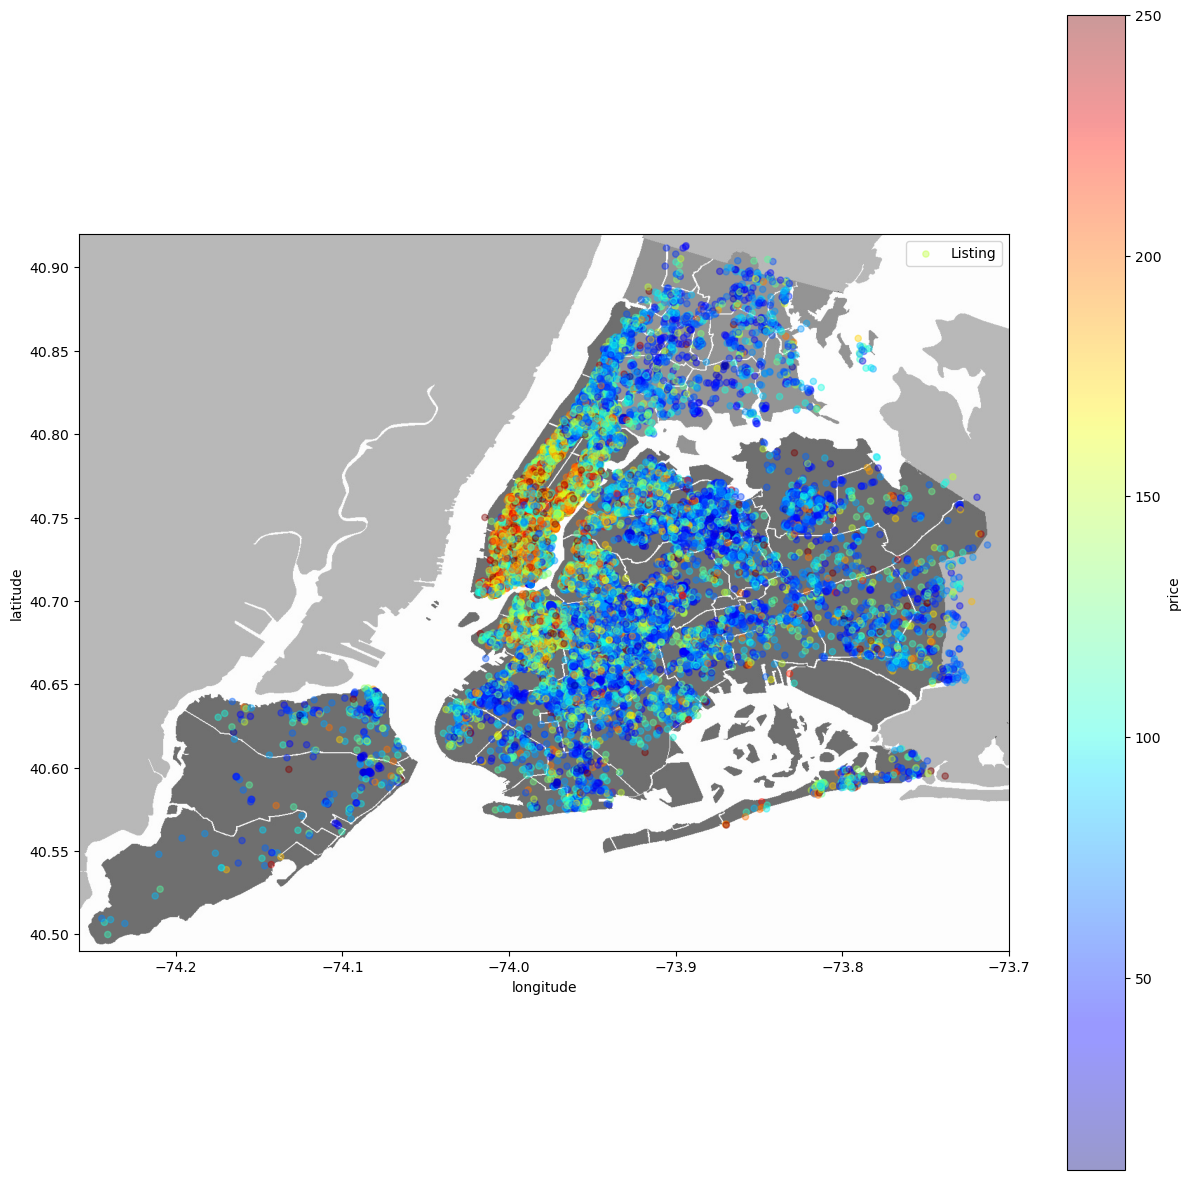

In [4]:
### Display the listings using an image of a map of New York ###
df = pd.read_csv("dataset/AB_NYC_2019.csv")

df_copy = df.copy()
df_copy = df_copy.loc[df_copy['price'] != 0]
df_copy = df_copy.loc[df_copy['price'] <= 250]
df_copy = df_copy.loc[df_copy['availability_365'] != 0]

plt.figure(figsize = (15, 15))
ax = plt.gca()

# Load the image
nyc_image = Image.open("img/New_York_City_.png")

# Plot the data using longitude and latitude
df_copy.plot(kind = 'scatter', x = 'longitude', y = 'latitude', label = 'Listing', c = 'price', ax = ax, 
        cmap = plt.get_cmap('jet'), colorbar = True, alpha = 0.4)

# Set the extent of the image to correctly display it
ax.imshow(nyc_image, extent = [-74.258, -73.7, 40.49, 40.92]);

# Preprocessing

In [7]:
X_train, X_test, X_val, y_train, y_test, y_val = preprocess(file_paths_global)

# Feature Selection

In [8]:
# Selected Features
selected_features = ['minimum_nights', 
                     'number_of_reviews', 
                     'reviews_per_month', 
                     'calculated_host_listings_count', 
                     'availability_365',
                     'Host Response Rate', 
                     'Accommodates', 
                     'Bathrooms', 
                     'Bedrooms', 
                     'Beds', 
                     'Square Feet',
                     'recency_last_review' ,
                     'last_review_day', 
                     'last_review_month', 
                     'last_review_year', 
                     'room_type_Entire home/apt', 
                     'room_type_Private room', 
                     'room_type_Shared room',
                     'mean_target_neighbourhood',
                     'mean_target_neighbourhood_group',
                     'neighbourhood_group_Bronx', 
                     'neighbourhood_group_Brooklyn',
                     'neighbourhood_group_Manhattan',
                     'neighbourhood_group_Queens',
                     'neighbourhood_group_Staten Island',
                     'x', 
                     'y', 
                     'z',
                     'text_encoding_tsne_1',
                     'text_encoding_tsne_2']

# Prepare feature matrices
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]
X_val_selected = X_val[selected_features]

X_train_np = X_train_selected.to_numpy()
X_test_np = X_test_selected.to_numpy()
X_val_np = X_val_selected.to_numpy()

scaler = MinMaxScaler()
X_train_np = scaler.fit_transform(X_train_np)
X_test_np = scaler.transform(X_test_np)
X_val_np = scaler.transform(X_val_np)

y_train_np = y_train.to_numpy().flatten()
y_test_np = y_test.to_numpy().flatten()
y_val_np = y_val.to_numpy().flatten()

X_test_selected.shape

(3619, 30)

# Load models

In [9]:
# Decision Tree
decision_tree = DecisionTreeRegressor(**load_params('models/saved_models/decision_tree_params.json'))

# Bagging
bagging = BaggingRegressor(**load_params('models/saved_models/bagging_params.json'))

# Random Forest
random_forest = RandomForestRegressor(**load_params('models/saved_models/random_forest_params.json'))

# Extremely randomized tree
extra_forest = ExtraTreesRegressor(**load_params('models/saved_models/extremely_randomized_forest_params.json'))

# Adaboost
adaboost = AdaBoostRegressor(**load_params('models/saved_models/adaboost_params.json'))

# sklearn gradient boosting
sk_gb = GradientBoostingRegressor(**load_params('models/saved_models/sk_gradient_boosting_params.json'))

# sklearn hist gradient boosting
hist_sk_gb = HistGradientBoostingRegressor(**load_params('models/saved_models/sk_hist_gradient_boosting_params.json'))

# lgbm
lgbm = LGBMRegressor(**load_params('models/saved_models/lgbm_params.json'))

# XGBOOST
xgb = xg.XGBRegressor(**load_params('models/saved_models/xgb_params.json'))

# CatBoost
catboost = CatBoostRegressor(**load_params('models/saved_models/catboost_params.json'))

# Voting
vote_weights = load_params('models/saved_models/vote_params.json')
weights_normalized = [w/sum(vote_weights.values()) for w in vote_weights.values()]
vote_estimators = [ ('xgb',xgb),('lgbm', lgbm),('hist_sk_gb', hist_sk_gb),('extra_forest', extra_forest),('random_forest', random_forest)]

# Stacking (Due to long runtime +5 minutes, we preferred to load the scores directly)
# Check stacking notebook in 'models' folder for detailed implementation
homemade_stacking_scores = load_params('models/saved_scores/homemade_stacking_scores.json')
sk_stacking_scores = load_params('models/saved_scores/sk_stacking_scores.json')

In [10]:
all_scores = []
model_names = [('Decision Tree',decision_tree),
                ('Bagging',bagging),
                ('Random Forest',random_forest),
                ('Extremely Randomized Forest',extra_forest),
                ('Adaboost',adaboost),
                ('sklearn Gradient Boosting',sk_gb),
                ('sklearn Hist Gradient Boosting',hist_sk_gb),
                ('LightGBM',lgbm),
                ('XGBoost',xgb),
               ('CatBoost', catboost)
               ]

for i in range(len(model_names)) :
    print('')
    print('')
    print('--- '+model_names[i][0]+' ---')
    print('')
    model = model_names[i][1]
    model.fit(X_train_np, y_train_np)
    y_pred = np.maximum(0,model.predict(X_test_np))
    score = scores(y_test_np,y_pred,plot=False)
    score['Model'] = model_names[i][0]
    all_scores.append(score)

print('')
print('--- Homemade Voting ---')
print('')
print('')

y_pred = vote_prediction(vote_estimators,X_train_np,y_train_np,X_test_np, weights_normalized)
score = scores(y_test_np,y_pred,plot=False)
score['Model'] = 'Homemade Voting'
all_scores.append(score)

print('')
print('--- Homemade Stacking ---')
print('')
print('')

for key in homemade_stacking_scores:
    print(key,':', homemade_stacking_scores[key])
homemade_stacking_scores['Model'] = 'Homemade stacking'
all_scores.append(homemade_stacking_scores)

print('')
print('--- sklearn Stacking ---')
print('')
print('')
for key in sk_stacking_scores:
    print(key,':', sk_stacking_scores[key])
sk_stacking_scores['Model'] = 'sklearn Stacking'
all_scores.append(sk_stacking_scores)



--- Decision Tree ---

R²: 0.47807739666812765
MAE: 45.8255977175727
MSE: 4669.256527186797
RMSE: 68.33195831517487
MAPE: 0.3711947323149145
error_ratio_rmse: 0.4940511628247337
error_ratio_mae: 0.33132651833391724


--- Bagging ---

R²: 0.5544971901954285
MAE: 41.776126217532465
MSE: 3985.5850068201553
RMSE: 63.13148981942494
MAPE: 0.3321188897694259
error_ratio_rmse: 0.45645093050433105
error_ratio_mae: 0.30204818133393396


--- Random Forest ---

R²: 0.5627451113355987
MAE: 41.07743077885374
MSE: 3911.796940594226
RMSE: 62.54435978243143
MAPE: 0.32214093099511787
error_ratio_rmse: 0.4522058849259789
error_ratio_mae: 0.2969964997715909


--- Extremely Randomized Forest ---

R²: 0.5617499201528038
MAE: 41.06960290091395
MSE: 3920.700181987488
RMSE: 62.61549474361349
MAPE: 0.325223859631188
error_ratio_rmse: 0.45272020225502996
error_ratio_mae: 0.296939902942026


--- Adaboost ---

R²: 0.4260360827605809
MAE: 48.83235880720346
MSE: 5134.831773583393
RMSE: 71.65774050012597
MAPE: 0.40

# Final Results

In [11]:
Final_Results = pd.DataFrame(all_scores)
Final_Results = Final_Results[['Model','R2','MAE','MSE','RMSE','MAPE','error_ratio_rmse','error_ratio_mae']] 
Final_Results.sort_values('R2',ascending=False)

,Model,R2,MAE,MSE,RMSE,MAPE,error_ratio_rmse,error_ratio_mae
11,Homemade stacking,0.574006,40.409499,3811.056886,61.733758,0.312093,0.446345,0.292167
10,Homemade Voting,0.573251,40.506392,3817.807805,61.788412,0.314359,0.446740,0.292868
8,XGBoost,0.569880,40.756571,3847.962707,62.031949,0.315426,0.448501,0.294677
7,LightGBM,0.567503,40.893731,3869.227835,62.203118,0.316006,0.449739,0.295668
9,CatBoost,0.564835,40.904796,3893.103788,62.394742,0.316990,0.451124,0.295748
2,Random Forest,0.562745,41.077431,3911.796941,62.544360,0.322141,0.452206,0.296996
3,Extremely Randomized Forest,0.561750,41.069603,3920.700182,62.615495,0.325224,0.452720,0.296940
6,sklearn Hist Gradient Boosting,0.559020,41.267632,3945.121306,62.810201,0.319405,0.454128,0.298372
1,Bagging,0.554497,41.776126,3985.585007,63.131490,0.332119,0.456451,0.302048
12,sklearn Stacking,0.550037,41.366705,4025.484549,63.446706,0.317317,0.458730,0.299088


# Conclusions

Our homemade stacking and voting algorithms showed the best results on all metrics, with XGBoost completing the top three.

sklearn Stacking performed poorly compared to the homemade, most probably due to the fact that the meta feature matrix cannot be appended to the initial features in sklearn's implementation.

This project was interesting as it allowed us to experiment and tune many different ensemble techniques and implement several algorithms and feature engineering approaches.